In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**TRAINING PART**

In [ ]:
import math, os, time, random
from dataclasses import dataclass
from typing import Optional, Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import RandAugment
import os

In [ ]:
def seed_everything(seed: int = 1337):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(1337)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
@dataclass
class Config:
    # Data / model
    img_size: int = 32
    num_classes: int = 10
    patch_size: int = 4
    embed_dim: int = 384
    depth: int = 8
    num_heads: int = 6
    mlp_ratio: float = 4.0
    drop_rate: float = 0.1
    attn_drop_rate: float = 0.0
    drop_path_rate: float = 0.1

    # Optim
    batch_size: int = 128
    epochs: int = 200
    warmup_epochs: int = 10
    base_lr: float = 5e-4
    min_lr: float = 5e-6
    weight_decay: float = 0.05
    betas: Tuple[float, float] = (0.9, 0.999)

    # Regularization
    label_smoothing: float = 0.1

    # Aug
    use_randaugment: bool = True
    randaugment_n: int = 2
    randaugment_m: int = 9

    # Misc
    num_workers: int = 2
    amp: bool = True

cfg = Config()
#print(cfg)
cfg

Config(img_size=32, num_classes=10, patch_size=4, embed_dim=384, depth=8, num_heads=6, mlp_ratio=4.0, drop_rate=0.1, attn_drop_rate=0.0, drop_path_rate=0.1, batch_size=128, epochs=200, warmup_epochs=10, base_lr=0.0005, min_lr=5e-06, weight_decay=0.05, betas=(0.9, 0.999), label_smoothing=0.1, use_randaugment=True, randaugment_n=2, randaugment_m=9, num_workers=2, amp=True)

In [ ]:
# @title Datasets & Dataloaders
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

train_tfms = [
    transforms.RandomCrop(cfg.img_size, padding=4),
    transforms.RandomHorizontalFlip(),
]
if cfg.use_randaugment:
    train_tfms.insert(0, RandAugment(num_ops=cfg.randaugment_n, magnitude=cfg.randaugment_m))

train_tfms += [
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
]

test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

train_set = datasets.CIFAR10(root="./data", train=True, download=True, transform=transforms.Compose(train_tfms))
test_set  = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tfms)

train_loader = DataLoader(train_set, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, pin_memory=True)
len(train_set), len(test_set)


100%|██████████| 170M/170M [00:03<00:00, 42.8MB/s]


(50000, 10000)

In [ ]:
# @title ViT Blocks
class PatchEmbed(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=384):
        super().__init__()
        assert img_size % patch_size == 0
        self.grid_size = img_size // patch_size
        self.num_patches = self.grid_size ** 2
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)               # (B, D, H/ps, W/ps)
        x = x.flatten(2).transpose(1, 2)  # (B, N, D)
        return x

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=6, attn_drop=0., proj_drop=0.):
        super().__init__()
        assert dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # (B, heads, N, head_dim)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = attn @ v  # (B, heads, N, head_dim)
        x = x.transpose(1,2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class DropPath(nn.Module):
    """Stochastic Depth per sample."""
    def __init__(self, drop_prob: float = 0.):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        return x.div(keep_prob) * random_tensor

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., drop=0., attn_drop=0., drop_path=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = MultiHeadSelfAttention(dim, num_heads, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = nn.LayerNorm(dim)
        self.mlp   = MLP(dim, int(dim*mlp_ratio), drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10,
                 embed_dim=384, depth=8, num_heads=6, mlp_ratio=4.0,
                 drop_rate=0.1, attn_drop_rate=0.0, drop_path_rate=0.1):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop  = nn.Dropout(p=drop_rate)

        # stochastic depth decay rule
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]
        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, drop=drop_rate,
                  attn_drop=attn_drop_rate, drop_path=dpr[i])
            for i in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.02)
            if m.bias is not None: nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.zeros_(m.bias); nn.init.ones_(m.weight)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)            # (B, N, D)
        cls = self.cls_token.expand(B, -1, -1)  # (B,1,D)
        x = torch.cat((cls, x), dim=1)     # (B, N+1, D)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        cls_out = x[:, 0]
        return self.head(cls_out)


In [ ]:
# @title Training Utils: loss/metrics/schedule
class LabelSmoothingCE(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, preds, targets):
        n_classes = preds.size(-1)
        log_probs = F.log_softmax(preds, dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(log_probs)
            true_dist.fill_(self.smoothing / (n_classes - 1))
            true_dist.scatter_(1, targets.data.unsqueeze(1), 1.0 - self.smoothing)
        return torch.mean(torch.sum(-true_dist * log_probs, dim=-1))

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return 100.0 * correct / total

class WarmupCosine:
    def __init__(self, optimizer, base_lr, min_lr, epochs, steps_per_epoch, warmup_epochs=10):
        self.opt = optimizer
        self.base_lr = base_lr
        self.min_lr = min_lr
        self.total_steps = epochs * steps_per_epoch
        self.warmup_steps = max(1, warmup_epochs * steps_per_epoch)
        self.global_step = 0

    def step(self):
        self.global_step += 1
        if self.global_step < self.warmup_steps:
            lr = self.base_lr * self.global_step / self.warmup_steps
        else:
            t = (self.global_step - self.warmup_steps) / (self.total_steps - self.warmup_steps)
            lr = self.min_lr + 0.5*(self.base_lr - self.min_lr)*(1 + math.cos(math.pi*t))
        for pg in self.opt.param_groups:
            pg["lr"] = lr
        return lr


In [ ]:
# @title Train!
model = VisionTransformer(
    img_size=cfg.img_size,
    patch_size=cfg.patch_size,
    num_classes=cfg.num_classes,
    embed_dim=cfg.embed_dim,
    depth=cfg.depth,
    num_heads=cfg.num_heads,
    mlp_ratio=cfg.mlp_ratio,
    drop_rate=cfg.drop_rate,
    attn_drop_rate=cfg.attn_drop_rate,
    drop_path_rate=cfg.drop_path_rate,
).to(device)

criterion = LabelSmoothingCE(cfg.label_smoothing)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=cfg.base_lr, betas=cfg.betas, weight_decay=cfg.weight_decay
)

scaler = torch.cuda.amp.GradScaler(enabled=cfg.amp)
sched = WarmupCosine(
    optimizer, base_lr=cfg.base_lr, min_lr=cfg.min_lr,
    epochs=cfg.epochs, steps_per_epoch=len(train_loader),
    warmup_epochs=cfg.warmup_epochs
)

best_acc = 0.0
base_dir = "/content/drive/MyDrive/ViT"
#best_path = "vit_cifar10_best.pt"
best_path = os.path.join(base_dir, "vit_cifar10_best.pt")
save_dir = os.path.join(base_dir, "checkpoints")
os.makedirs(save_dir, exist_ok=True)
start = time.time()

for epoch in range(1, cfg.epochs+1):
    model.train()
    running_loss = 0.0
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=cfg.amp):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        lr = sched.step()
        running_loss += loss.item()

    test_acc = evaluate(model, test_loader)
 #   if test_acc > best_acc:
 #       best_acc = test_acc
 #       torch.save({
 #           "model": model.state_dict(),
 #           "cfg": cfg.__dict__,
 #           "acc": best_acc,
 #           "epoch": epoch
 #       }, best_path)

 #   if epoch % 5 == 0:
 #       ckpt_path = os.path.join(save_dir, f"vit_epoch_{epoch}.pt")
 #       torch.save({
 #           "model": model.state_dict(),
 #           "cfg": cfg.__dict__,
 #           "acc": test_acc,
 #           "epoch": epoch
 #       }, ckpt_path)

    if test_acc > best_acc:
        best_acc = test_acc
        torch.save({
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scaler": scaler.state_dict(),
            "sched_step": sched.global_step,
            "cfg": cfg.__dict__,
            "acc": best_acc,
            "epoch": epoch
        }, best_path)

    if epoch % 5 == 0:
        ckpt_path = os.path.join(save_dir, f"vit_epoch_{epoch}.pt")
        torch.save({
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scaler": scaler.state_dict(),
            "sched_step": sched.global_step,
            "cfg": cfg.__dict__,
            "acc": test_acc,
            "epoch": epoch
        }, ckpt_path)

    print(f"Epoch {epoch:03d}/{cfg.epochs} | loss {running_loss/len(train_loader):.4f} | "
          f"test_acc {test_acc:.2f}% | best {best_acc:.2f}% | lr {lr:.6f}")

total_min = (time.time() - start) / 60
print(f"Training finished in {total_min:.1f} min. Best test acc: {best_acc:.2f}%")


/tmp/ipython-input-2545625227.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=cfg.amp)
/tmp/ipython-input-2545625227.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.amp):


Epoch 001/200 | loss 2.2047 | test_acc 32.47% | best 32.47% | lr 0.000050
Epoch 002/200 | loss 1.9650 | test_acc 37.95% | best 37.95% | lr 0.000100
Epoch 003/200 | loss 1.8407 | test_acc 46.02% | best 46.02% | lr 0.000150
Epoch 004/200 | loss 1.7729 | test_acc 46.25% | best 46.25% | lr 0.000200
Epoch 005/200 | loss 1.7319 | test_acc 49.38% | best 49.38% | lr 0.000250
Epoch 006/200 | loss 1.7054 | test_acc 50.55% | best 50.55% | lr 0.000300
Epoch 007/200 | loss 1.6898 | test_acc 51.09% | best 51.09% | lr 0.000350
Epoch 008/200 | loss 1.6789 | test_acc 52.85% | best 52.85% | lr 0.000400
Epoch 009/200 | loss 1.6732 | test_acc 53.69% | best 53.69% | lr 0.000450
Epoch 010/200 | loss 1.6760 | test_acc 53.15% | best 53.69% | lr 0.000500
Epoch 011/200 | loss 1.6585 | test_acc 54.53% | best 54.53% | lr 0.000500
Epoch 012/200 | loss 1.6407 | test_acc 54.38% | best 54.53% | lr 0.000500
Epoch 013/200 | loss 1.6240 | test_acc 55.84% | best 55.84% | lr 0.000500
Epoch 014/200 | loss 1.6199 | test_acc

In [ ]:
model = VisionTransformer(
    img_size=cfg.img_size,
    patch_size=cfg.patch_size,
    num_classes=cfg.num_classes,
    embed_dim=cfg.embed_dim,
    depth=cfg.depth,
    num_heads=cfg.num_heads,
    mlp_ratio=cfg.mlp_ratio,
    drop_rate=cfg.drop_rate,
    attn_drop_rate=cfg.attn_drop_rate,
    drop_path_rate=cfg.drop_path_rate,
).to(device)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return 100.0 * correct / total


In [ ]:
# @title Reload best and final evaluate
ckpt = torch.load("/content/drive/MyDrive/ViT/vit_cifar10_best.pt", map_location=device)
model.load_state_dict(ckpt["model"])
acc = evaluate(model, test_loader)
print(f"Reloaded best epoch {ckpt['epoch']} | accuracy {acc:.2f}% (stored {ckpt['acc']:.2f}%)")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Reloaded best epoch 195 | accuracy 86.12% (stored 86.12%)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


              precision    recall  f1-score   support

    airplane     0.8691    0.8700    0.8696      1000
  automobile     0.9229    0.9340    0.9284      1000
        bird     0.8414    0.8220    0.8316      1000
         cat     0.7238    0.7310    0.7274      1000
        deer     0.8615    0.8400    0.8506      1000
         dog     0.7842    0.7850    0.7846      1000
        frog     0.8960    0.8870    0.8915      1000
       horse     0.8893    0.8920    0.8907      1000
        ship     0.9276    0.9350    0.9313      1000
       truck     0.8954    0.9160    0.9056      1000

    accuracy                         0.8612     10000
   macro avg     0.8611    0.8612    0.8611     10000
weighted avg     0.8611    0.8612    0.8611     10000



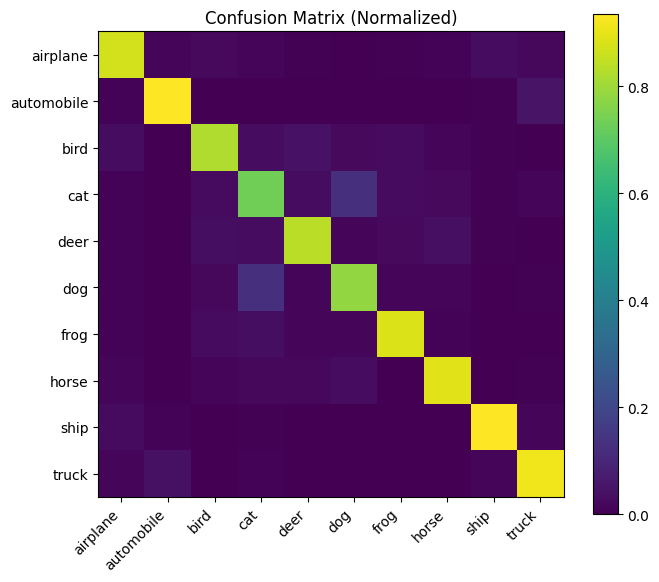

In [ ]:
!pip -q install scikit-learn

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(yb.numpy())

y_true = np.concatenate(all_labels)
y_pred = np.concatenate(all_preds)

# Per-class metrics
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

# Confusion matrix (normalized)
cm = confusion_matrix(y_true, y_pred, labels=range(10))
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(7,6))
plt.imshow(cm_norm, interpolation='nearest')
plt.title('Confusion Matrix (Normalized)')
plt.colorbar()
plt.xticks(range(10), classes, rotation=45, ha='right')
plt.yticks(range(10), classes)
plt.tight_layout()
plt.show()


**RUN THE CODE**

In [2]:
import math, os, time, random
from dataclasses import dataclass
from typing import Optional, Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import RandAugment

In [4]:
## configurations

@dataclass
class Config:
    # Data / model
    img_size: int = 32
    num_classes: int = 10
    patch_size: int = 4
    embed_dim: int = 384
    depth: int = 8
    num_heads: int = 6
    mlp_ratio: float = 4.0
    drop_rate: float = 0.1
    attn_drop_rate: float = 0.0
    drop_path_rate: float = 0.1

    # Optim
    batch_size: int = 128
    epochs: int = 200
    warmup_epochs: int = 10
    base_lr: float = 5e-4
    min_lr: float = 5e-6
    weight_decay: float = 0.05
    betas: Tuple[float, float] = (0.9, 0.999)

    # Regularization
    label_smoothing: float = 0.1

    # Aug
    use_randaugment: bool = True
    randaugment_n: int = 2
    randaugment_m: int = 9

    # Misc
    num_workers: int = 2
    amp: bool = True

cfg = Config()


##Load the datset

CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

train_tfms = [
    transforms.RandomCrop(cfg.img_size, padding=4),
    transforms.RandomHorizontalFlip(),
]
if cfg.use_randaugment:
    train_tfms.insert(0, RandAugment(num_ops=cfg.randaugment_n, magnitude=cfg.randaugment_m))

train_tfms += [
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
]

test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

train_set = datasets.CIFAR10(root="./data", train=True, download=True, transform=transforms.Compose(train_tfms))
test_set  = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tfms)

train_loader = DataLoader(train_set, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, pin_memory=True)
len(train_set), len(test_set)

100%|██████████| 170M/170M [00:06<00:00, 28.1MB/s]


(50000, 10000)

In [5]:
##Seed function

def seed_everything(seed: int = 1337):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(1337)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

##   VIT   ##

class PatchEmbed(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=384):
        super().__init__()
        assert img_size % patch_size == 0
        self.grid_size = img_size // patch_size
        self.num_patches = self.grid_size ** 2
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)               # (B, D, H/ps, W/ps)
        x = x.flatten(2).transpose(1, 2)  # (B, N, D)
        return x

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=6, attn_drop=0., proj_drop=0.):
        super().__init__()
        assert dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # (B, heads, N, head_dim)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = attn @ v  # (B, heads, N, head_dim)
        x = x.transpose(1,2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class DropPath(nn.Module):
    """Stochastic Depth per sample."""
    def __init__(self, drop_prob: float = 0.):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        return x.div(keep_prob) * random_tensor

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., drop=0., attn_drop=0., drop_path=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = MultiHeadSelfAttention(dim, num_heads, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = nn.LayerNorm(dim)
        self.mlp   = MLP(dim, int(dim*mlp_ratio), drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10,
                 embed_dim=384, depth=8, num_heads=6, mlp_ratio=4.0,
                 drop_rate=0.1, attn_drop_rate=0.0, drop_path_rate=0.1):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop  = nn.Dropout(p=drop_rate)

        # stochastic depth decay rule
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]
        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, drop=drop_rate,
                  attn_drop=attn_drop_rate, drop_path=dpr[i])
            for i in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.02)
            if m.bias is not None: nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.zeros_(m.bias); nn.init.ones_(m.weight)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)            # (B, N, D)
        cls = self.cls_token.expand(B, -1, -1)  # (B,1,D)
        x = torch.cat((cls, x), dim=1)     # (B, N+1, D)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        cls_out = x[:, 0]
        return self.head(cls_out)


## model ###
model = VisionTransformer(
    img_size=cfg.img_size,
    patch_size=cfg.patch_size,
    num_classes=cfg.num_classes,
    embed_dim=cfg.embed_dim,
    depth=cfg.depth,
    num_heads=cfg.num_heads,
    mlp_ratio=cfg.mlp_ratio,
    drop_rate=cfg.drop_rate,
    attn_drop_rate=cfg.attn_drop_rate,
    drop_path_rate=cfg.drop_path_rate,
).to(device)

# evaluate function
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return 100.0 * correct / total

ckpt = torch.load("/content/drive/MyDrive/ViT/vit_cifar10_best.pt", map_location=device)
model.load_state_dict(ckpt["model"])
acc = evaluate(model, test_loader)
print(f"Reloaded best epoch {ckpt['epoch']} | accuracy {acc:.2f}% (stored {ckpt['acc']:.2f}%)")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Reloaded best epoch 195 | accuracy 86.12% (stored 86.12%)
